In [ ]:
%pip install mplfinance
%pip install pandas_ta

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import mplfinance as mpf
import pandas_ta as ta

In [12]:

# Anchored VWAP displays the volume-weighted average price for a specific time period, starting from a user-selected point. 
# Shows the price of an asset adjusted for its volume starting from any point chosen on the chart.
# This is a powerful tool because it takes into account the number of shares traded at each price level and presents it as a smooth line.
# https://school.stockcharts.com/doku.php?id=technical_indicators:anchored_vwap

def calc_vwap(df, anchor):
    if not anchor:
        temp_df = df.copy()
    elif anchor in df.index:
        temp_df = df.loc[anchor:].copy()
    else:
        raise ValueError('Anchor date not in index')

    temp_df['hlc'] = (temp_df['High'] + temp_df['Low'] + temp_df['Close']) / 3
    temp_df['vwap'] = (temp_df['hlc'] * temp_df['Volume']).cumsum() /temp_df['Volume'].cumsum()

    # find the 7 day MA
    temp_df['RSI'] = ta.rsi(temp_df['Close'], length=7)
    return temp_df








[*********************100%***********************]  1 of 1 completed
high price day2022-01-04 00:00:00
low price day2009-03-06 00:00:00
high volume day2008-10-10 00:00:00


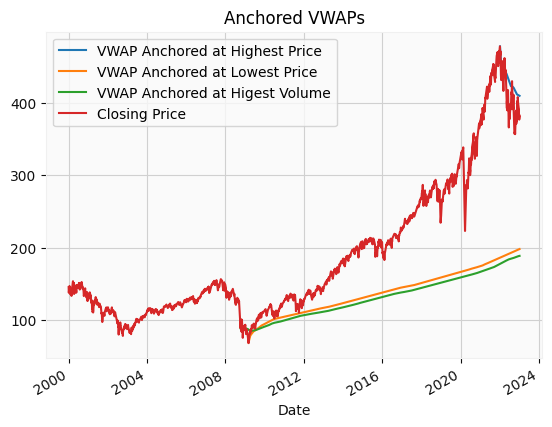

In [16]:
# Get data from yahoo finance
data = yf.download('SPY','2000-01-01','2023-01-04', interval='1d')

# find the date and time of the highest and lowest price and volume candles in the last lb periods (lookback)
# lb = 365*3

# date_time_of_highest_price = data['High'][len(data)-lb:].idxmax()
# date_time_of_lowest_price = data['Low'][len(data)-lb:].idxmin()
# date_time_of_highest_volume = data['Volume'][len(data)-lb:].idxmax()


date_time_of_highest_price = data['High'].idxmax()
date_time_of_lowest_price = data['Low'].idxmin()
date_time_of_highest_volume = data['Volume'].idxmax()


# a = calc_vwap(data, '2023-01-03 10:56:00-05:00')['vwap']
dthp_anchor = calc_vwap(data, date_time_of_highest_price)['vwap']
dtlp_anchor = calc_vwap(data, date_time_of_lowest_price)['vwap']
dthv_anchor = calc_vwap(data, date_time_of_highest_volume)['vwap']

#fill the first N rows with NaNs so that the length of the series is the same as the original data

print("high price day" + str(date_time_of_highest_price))
print("low price day" + str(date_time_of_lowest_price))
print("high volume day" + str(date_time_of_highest_volume))

# data_mins = yf.download('SPY','2023-01-01','2023-01-05', interval='1m')

dthp_anchor.plot()
dtlp_anchor.plot()
dthv_anchor.plot()
data['Close'].plot()

#add dthp_anchor to the mpf plot so that it displays on the chart along with the candlestick chart, iff the plot to add is a series that is shorter than the original data, fill the first N rows with NaNs so that the length of the series is the same as the original data

plt.title('Anchored VWAPs')
plt.legend(['VWAP Anchored at Highest Price', 'VWAP Anchored at Lowest Price', 'VWAP Anchored at Higest Volume', 'Closing Price'])
plt.show()



In [17]:
#use mpf to plot the candlestick chart of data along with the VWAPs
dthp_anchor_adj = pd.Series(np.nan, index=data.index) #create a series of NaNs with the same index as data
dthp_anchor_adj.update(dthp_anchor) #update the first N rows of dthp_anchor_adj with the values from dthp_anchor
dtlp_anchor_adj = pd.Series(np.nan, index=data.index) #create a series of NaNs with the same index as data
dtlp_anchor_adj.update(dtlp_anchor) #update the first N rows of dtlp_anchor_adj with the values from dtlp_anchor
dthv_anchor_adj = pd.Series(np.nan, index=data.index) #create a series of NaNs with the same index as data
dthv_anchor_adj.update(dthv_anchor) #update the first N rows of dthv_anchor_adj with the values from dthv_anchor


/Users/armaan/.pyenv/versions/3.10.4/lib/python3.10/site-packages/mplfinance/_arg_validators.py:83: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


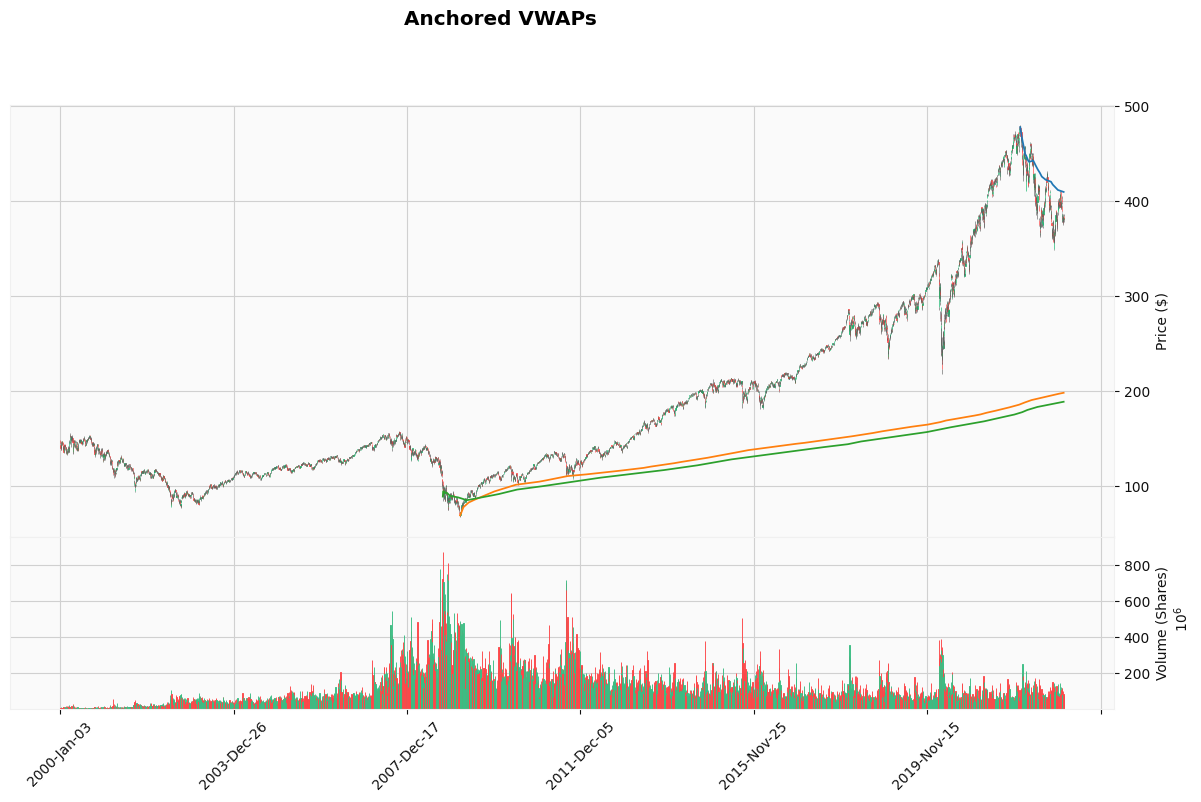

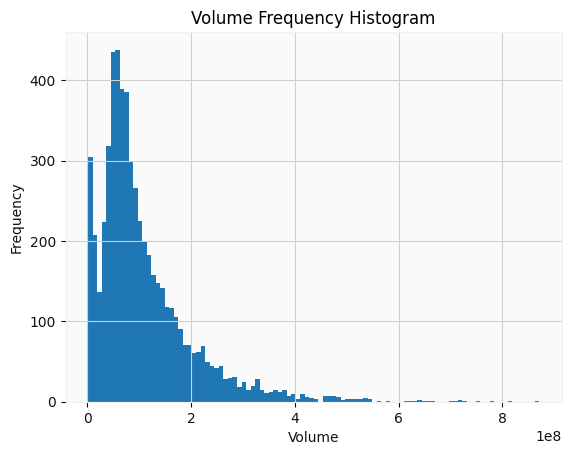

In [18]:

mpf.plot(data, type='candle', style='yahoo', title='Anchored VWAPs', addplot=[mpf.make_addplot(dthp_anchor_adj), mpf.make_addplot(dtlp_anchor_adj), mpf.make_addplot(dthv_anchor_adj)], volume=True, ylabel='Price ($)', ylabel_lower='Volume (Shares)', figratio=(16,9), figscale=1.5)
#add legend to mpf plot


plt.hist(data['Volume'], bins=100)
plt.title('Volume Frequency Histogram')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.show()


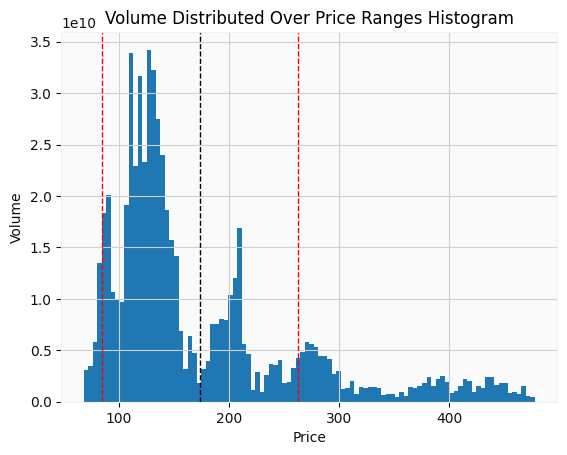

In [325]:

#now plot volume distributed over price ranges as bins in a histogram
plt.hist(data['Close'], bins=100, weights=data['Volume'])
#The mean of the data is the average price weighted by volume

mean_of_vol_w_price = np.average(data['Close'], weights=data['Volume'])
#The standard deviation of the data is the standard deviation of the price weighted by volume
std_price_w_vol = np.sqrt(np.average((data['Close']-mean_of_vol_w_price)**2, weights=data['Volume']))

sigma = std_price_w_vol

plt.axvline(mean_of_vol_w_price, color='k', linestyle='dashed', linewidth=1)
plt.axvline(mean_of_vol_w_price+float(sigma), color='r', linestyle='dashed', linewidth=1)
plt.axvline(mean_of_vol_w_price-float(sigma), color='r', linestyle='dashed', linewidth=1)

plt.title('Volume Distributed Over Price Ranges Histogram')
plt.xlabel('Price')
plt.ylabel('Volume')
#show grid
plt.grid(True)
#make the x axis bins more narrow

plt.show()


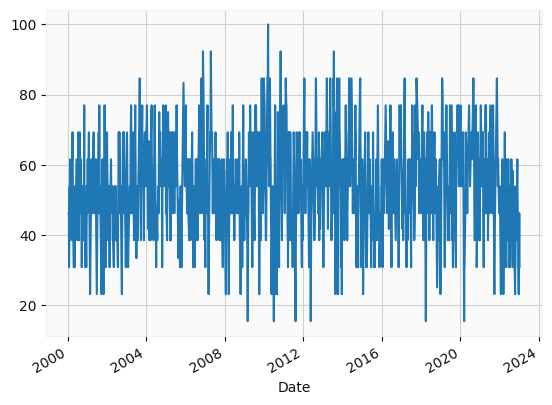

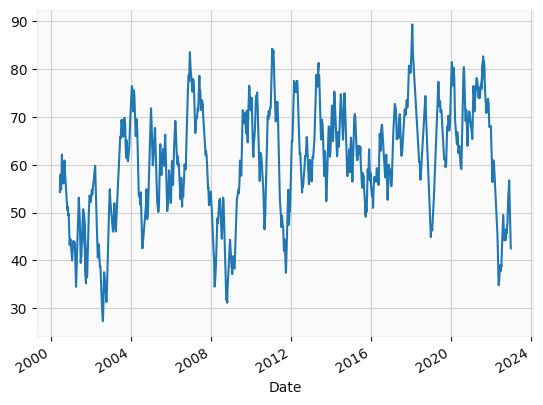

In [11]:
# do it in scratch pandas and numpy
data["RSI"] = data["Close"].rolling(14).apply(lambda x: 100 - 100 / (1 + (x.diff(1).dropna() > 0).sum() / (x.diff(1).dropna() < 0).abs().sum()))
data["RSI"].plot()
plt.show()

#add a stochastic indicator to track derivative motion of the price
data['stochastic'] = data['Close'].rolling(14).apply(lambda x: 100 * (x[-1] - x.min()) / (x.max() - x.min()))
data['ma_of_stoch'] = data['stochastic'].rolling(100).mean()
data['ma_of_stoch'].plot()
plt.show()